# Explore basins and states: all-to-all

In [4]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [5]:
def nearest_neighbors(N, d, r, kind="strict"):
    """
    Create a d-uniform hypergraph representing nearest neighbor relationships.

    Parameters
    ----------
    N : int
        The total number of nodes.

    d : int
        Size of hyperedges

    r : int
        The range of neighbors to consider. Neighbors within the range [-r, r]
        (excluding the node itself) will be connected.

    Returns
    -------
    xgi.Hypergraph
        A hypergraph object representing the nearest neighbor relationships.

    Raises:
    ------
    """

    r_min = int(np.ceil((d - 1) / 2))
    if r < r_min:
        raise ValueError(f"r must be >= ceil((d - 1) / 2) = {r_min} to have edges.")

    H = xgi.Hypergraph()

    nodes = np.arange(N)

    edges = []
    neighbor_rel_ids = np.concatenate((np.arange(-r, 0), np.arange(1, r + 1)))

    for i in nodes:
        neighbor_ids = i + neighbor_rel_ids
        edge_neighbors_i = combinations(neighbor_ids, d - 1)
        if kind == "strict":
            edge_neighbors_i = [el for el in edge_neighbors_i if max(el) - min(el) <= r]
        edges_i = [(i, *comb) for comb in edge_neighbors_i]
        edges = edges + edges_i

    edges = np.mod(edges, N)

    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    H.cleanup()  # remove duplicate edges
    return H

## Generate structure

In [6]:
N = 100
# H = xgi.complete_hypergraph(N, max_order=2)

r1 = 2
r2 = 2

H2 = nearest_neighbors(N, d=3, r=r2, kind=None)
H1 = nearest_neighbors(N, d=2, r=r1, kind=None)
H = H1 << H2

print(H)

Unnamed Hypergraph with 100 nodes and 600 hyperedges


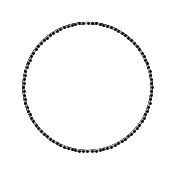

In [7]:
fig, ax = plt.subplots(figsize=(2, 2))
pos = xgi.circular_layout(H)

ax, ims = xgi.draw(H, pos=pos, ax=ax, node_size=1, edge_fc="r", alpha=0.1)

plt.show()

In [8]:
ims[2].get_zorder()

1

In [20]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)
adj2 = xgi.adjacency_matrix(H, order=2, sparse=False)
k1_avg = H.nodes.degree(order=1).mean()
k2_avg = H.nodes.degree(order=2).mean()

## Dynamics

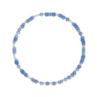

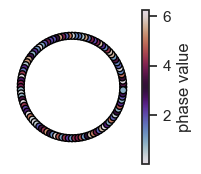

In [10]:
# Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 0  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None


psi_init = generate_state(N, kind=ic, q=2, noise=noise)

# integration
t_end = 200
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5
)
plt.colorbar(ims[0], label="phase value")

In [16]:
def rhs_pairwise_triplet_all_sym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_sym(t, psi, omega, k1, k2)
        - omega
    )

    return out


def rhs_pairwise_triplet_all_asym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_asym(t, psi, omega, k1, k2)
        - omega
    )

    return out


def rhs_pairwise_triplet_all_sym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_sym(t, psi, omega, k1, k2)
        - omega
    )

    return out


from numba import jit


def rhs_23_nn_sym_micro(t, psi, omega, k1, k2, r1, r2, links, triangles):
    N = len(psi)
    pairwise = np.zeros(N)
    triplet = np.zeros(N)

    for i, j in links:
        # sin(oj - oi)
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)
        pairwise[j] += sin(oi - oj)

    for i, j, k in triangles:
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / r1) * pairwise + (k2 / g2) * (triplet / 2)


def rhs_23_nn_sym(t, psi, omega, k1, k2, r1, r2, adj1, adj2):
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    sum_cos_psi = adj2.dot(cos_psi)
    sum_sin_psi = adj2.dot(sin_psi)

    # oj + ok - 2oi
    triplet = (
        -2 * sum_cos_psi**2 * sin_psi * cos_psi
        + cos_psi**2 * sum_cos_psi * sum_sin_psi
        - sum_cos_psi * sin_psi**2 * sum_sin_psi
        + sum_cos_psi * cos_psi**2 * sum_sin_psi
        - sum_cos_psi * sin_psi**2 * sum_sin_psi
        + 2 * cos_psi * sin_psi * sum_sin_psi**2
    )

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / r1) * pairwise + (k2 / g2) * triplet

In [40]:
from itertools import permutations


def adjacency_tensor(H, order):
    N = H.num_nodes
    shape = tuple([N] * (order + 1))
    tensor = np.zeros(shape)

    edges = H.edges.filterby("order", order)
    for id, members in edges.members(dtype=dict).items():
        for idcs in permutations(members):
            tensor[idcs] = 1

    return tensor

In [ ]:
def rhs_23_nn_sym_micro(t, psi, omega, k1, k2, r1, r2, links, triangles):
    N = len(psi)
    pairwise = np.zeros(N)
    triplet = np.zeros(N)

    for i, j in links:
        # sin(oj - oi)
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)
        pairwise[j] += sin(oi - oj)

    for i, j, k in triangles:
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

In [49]:
adj2

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [52]:
adj_tensor2 = adjacency_tensor(H, order=2)

In [34]:
pairwise

array([-1.29060683,  0.72512399, -1.45960801, -0.57147108,  1.61033036,
       -0.14518709, -0.52758301,  0.86564071,  0.11591221,  0.56219682,
       -1.38020713, -0.137563  , -0.54421282,  2.75864161,  0.83829927,
       -3.45897556,  1.10985175,  2.40657076, -2.73057841,  0.38901132,
       -0.38555708,  1.14136022, -0.37075825, -0.62264133, -0.39442017,
        0.35083011,  2.07297385, -2.13672205, -0.15159493, -0.75622301,
        1.24162012, -0.23264084, -0.59353189,  1.96469237,  1.8784807 ,
       -2.35008909, -1.5357253 ,  2.17610116, -1.86213898,  1.13784818,
        0.85292553, -1.33268192,  0.41712125,  0.01332362, -0.12000985,
       -0.46116003,  0.93527316, -0.71542775,  0.35339857,  1.59261795,
       -2.24437475,  1.85294209, -0.72950509, -2.62916034,  3.26988353,
       -1.71757401,  0.0433138 ,  0.65728319, -1.31163269,  1.68689937,
        0.03687677,  1.1538608 , -0.8544029 , -1.09287956,  1.38284124,
       -1.12794767, -1.59192298,  1.59848499, -0.0927817 ,  0.81

In [51]:
%timeit rhs_pairwise(0, psi_init, omega, k1, k2, adj1)

9.93 µs ± 82.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [52]:
%timeit rhs_pairwise_micro(0, psi_init, omega, k1, k2, links)

95.1 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
%timeit rhs_23_nn_sym_micro(0, psi_init, omega, k1, k2, r1, r2, links, triangles)

472 µs ± 5.76 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [55]:
%timeit rhs_23_nn_sym(0, psi_init, omega, k1, k2, r1, r2, links, triangles)

27.3 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
xx = rhs_23_nn_sym_micro(
    0, psi_init, omega, k1, k2, r1=r1, r2=r2, links=links, triangles=triangles
)
yy = rhs_23_nn_sym(0, psi_init, omega, k1, k2, r1=r1, r2=r2, adj1=adj1, adj2=adj2)

In [27]:
xx

array([ 1.68432395e+00, -1.07424668e-02,  1.58493281e+00, -1.74232495e-01,
        2.20887359e+00, -5.35021970e-01,  2.05548228e+00,  1.49545870e+00,
        3.40149284e+00,  1.21336056e+00, -2.46583039e-01,  4.83387534e-01,
        5.91897119e-01,  7.90175858e-01,  3.37313267e+00, -7.45263709e-01,
        1.69440108e+00,  2.74952783e+00,  2.97918729e+00,  9.31242631e-01,
       -6.17196828e-01,  6.93042956e-02,  5.72681348e-01,  2.13624653e-01,
        3.46155832e-01,  1.53811142e+00,  6.89665772e-01,  2.36558841e+00,
        1.65182715e+00, -4.41918011e-02, -2.42009992e-01,  7.49337059e-01,
        2.34428561e+00,  3.24548886e+00,  1.25925505e+00, -2.19246997e+00,
       -1.96060360e+00,  3.92792130e+00,  3.20940610e-01,  1.61092720e+00,
        6.41020446e-01,  2.42410792e+00,  2.24664763e+00,  2.53169350e-01,
        6.61277051e-01,  4.47894741e-01,  1.46082557e+00,  5.58119683e-01,
        1.00600745e-01,  2.65201012e+00, -9.71995422e-01,  2.50726034e+00,
       -9.36576344e-01,  

In [28]:
yy

array([ 8.12581506e-03, -1.04019885e+00,  3.36728361e+00,  1.02681520e+00,
        1.44017215e+00,  1.36492622e+00,  2.39072922e+00,  5.29221582e-01,
        3.25085336e+00,  1.58704946e+00, -2.33302177e+00,  5.29951203e-01,
        1.32665552e+00, -3.36628318e+00,  3.88326809e+00, -8.45694808e+00,
        7.91907380e+00,  4.29345035e+00,  9.74195136e+00, -6.40917615e-01,
        1.39919727e+00,  2.63073166e+00, -4.67343499e+00,  9.74612005e-01,
        9.26200738e-01,  1.72690803e+00,  2.22187262e+00,  7.60294829e+00,
        4.07052682e+00, -2.07008710e+00, -2.02354597e+00,  3.68685782e-01,
        7.48703913e+00,  4.29360675e+00, -7.68927212e-01, -6.62700558e+00,
       -1.73574591e-01,  3.31795792e+00,  4.51654886e+00,  1.39981556e+00,
       -1.77428601e+00,  3.20885053e+00,  8.46770918e-01,  3.44301122e+00,
        1.08755011e+00,  6.61884289e-01,  2.35821111e+00,  1.36501545e+00,
       -2.39687483e+00,  8.95177014e-01, -1.77676677e+00,  5.81817314e+00,
       -3.12173462e+00,  

In [49]:
n_reps = 100

# simulate
kwargs = {
    #    "adj1": adj1,
    "links": links,
    "triangles": triangles,
    "k1_avg": k1_avg,
    "k2_avg": k2_avg,
}

thetas_arr = np.zeros((n_reps, N, len(times)))

for i in tqdm(range(n_reps)):
    psi_init = generate_state(N, kind="random", noise=noise)

    thetas, times = simulate_kuramoto(
        H,
        k1,
        k2,
        omega=omega,
        theta_0=psi_init,
        t_end=t_end,
        dt=dt,
        rhs=rhs_pairwise_triplet_all_asym,  # rhs_pairwise_all
        # **kwargs
    )

    thetas_arr[i] = thetas

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


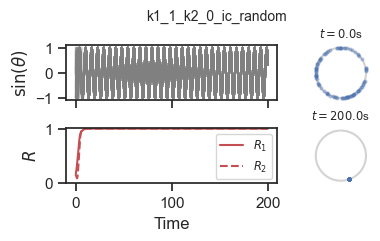

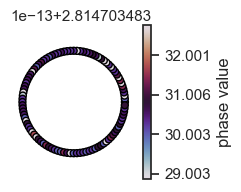

In [50]:
# plot the last repetition
i = 3
fig, axs = plot_sync(thetas_arr[i], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H,
    pos=pos,
    node_fc=thetas_arr[i, :, -1] % (2 * np.pi),
    node_fc_cmap="twilight",
    node_size=5,
)
plt.colorbar(ims[0], label="phase value")

In [51]:
states = [identify_state(thetas, atol=0.01) for thetas in thetas_arr]
set(states)

{'sync'}

In [52]:
states_unique, counts = np.unique(states, return_counts=True)
states_unique, counts

(array(['sync'], dtype='<U4'), array([100]))

In [53]:
states

['sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync']

In [ ]:
plt.hist(states)

## Loop over k2

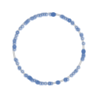

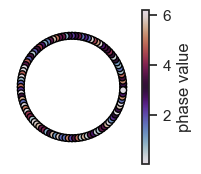

In [14]:
###### Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 0  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None


psi_init = generate_state(N, kind=ic, q=2, noise=noise)

# integration
t_end = 200
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5
)
plt.colorbar(ims[0], label="phase value")

In [15]:
n_reps = 10

k2s = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# simulate
kwargs = {
    "links": links,
    "triangles": triangles,
    #    "k1_avg": k1_avg,
    #    "k2_avg": k2_avg
    "r1": r1,
    "r2": r2,
}

thetas_arr = np.zeros((n_reps, len(k2s), N, len(times)))

for j, k2 in enumerate(k2s):
    for i in tqdm(range(n_reps)):
        psi_init = generate_state(N, kind="random", noise=noise)

        thetas, times = simulate_kuramoto(
            H,
            k1,
            k2,
            omega=omega,
            theta_0=psi_init,
            t_end=t_end,
            dt=dt,
            rhs=rhs_23_nn_sym,  # rhs_pairwise_all  #rhs_triplet_all_asym
            **kwargs
        )

        thetas_arr[i, j] = thetas

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


In [62]:
results = {}

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in thetas_arr[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 7/7 [01:41<00:00, 14.46s/it]


In [63]:
results

{0: {'-1-twisted': 0.07,
  '-2-twisted': 0.02,
  '-3-twisted': 0.02,
  '1-twisted': 0.04,
  '2-twisted': 0.02,
  '3-twisted': 0.02,
  'other': 0.48,
  'sync': 0.33},
 0.5: {'-2-twisted': 0.01, '2-cluster': 0.47, 'other': 0.52},
 1: {'2-cluster': 0.37, 'other': 0.63},
 1.5: {'2-cluster': 0.36, 'other': 0.64},
 2: {'2-cluster': 0.34, 'other': 0.66},
 2.5: {'2-cluster': 0.31, 'other': 0.69},
 3: {'2-cluster': 0.35, 'other': 0.65}}

In [64]:
import pandas as pd

In [65]:
df = pd.DataFrame.from_dict(results, orient="index").reset_index(names="k2")
df

,k2,-1-twisted,-2-twisted,-3-twisted,1-twisted,2-twisted,3-twisted,other,sync,2-cluster
0,0.0,0.07,0.02,0.02,0.04,0.02,0.02,0.48,0.33,NaN
1,0.5,NaN,0.01,NaN,NaN,NaN,NaN,0.52,NaN,0.47
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,0.37
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,0.64,NaN,0.36
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.66,NaN,0.34
5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,0.69,NaN,0.31
6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,0.35


In [66]:
df_long = df.melt(id_vars="k2", var_name="state", value_name="proba")
df_long

,k2,state,proba
0,0.0,-1-twisted,0.07
1,0.5,-1-twisted,NaN
2,1.0,-1-twisted,NaN
3,1.5,-1-twisted,NaN
4,2.0,-1-twisted,NaN
...,...,...,...
58,1.0,2-cluster,0.37
59,1.5,2-cluster,0.36
60,2.0,2-cluster,0.34
61,2.5,2-cluster,0.31


In [3]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_long,
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    alpha=0.7,
    style="state",
    # hue_order=["sync", "2-cluster", "other"]
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel("k2, triplet coupling strength")

title = f"all-to-all, {ic} ic, {n_reps} reps \n rhs_pairwise_triplet_all_asym"
ax.set_title(title)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5))


sb.despine()
ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_a2a_ic_{ic}_nreps_{n_reps}_rhs_pairwise_triplet_all_asym"

# plt.savefig(f"{results_dir}{fig_name}.png", dpi=300, bbox_inches="tight")

NameError: name 'plt' is not defined

In [ ]:
df_long.to_csv()

'2-cluster'

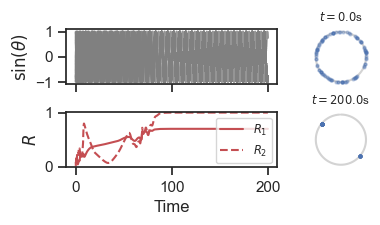

In [98]:
# plot the last repetition
i = 5
j = 3
fig, axs = plot_sync(thetas_arr[i, j], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

identify_state(thetas_arr[i, j])

# fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
# fig, ax = plt.subplots(figsize=(3, 3))
# ax, ims = xgi.draw(
#    H, pos=pos, node_fc=thetas_arr[i,j,-1] % (2 * np.pi), node_fc_cmap="twilight", node_size=5
# )
# plt.colorbar(ims[0], label="phase value")

In [148]:
dat = np.load("../code/thetas_arr.npy")

In [149]:
dat.shape

(100, 6, 30, 20001)

In [152]:
results = {}
k2s = [0, 0.5, 1, 1.5, 2, 2.5]

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in dat[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.60s/it]


In [153]:
results

{0: {'sync': 1.0},
 0.5: {'sync': 1.0},
 1: {'sync': 1.0},
 1.5: {'sync': 1.0},
 2: {'sync': 1.0},
 2.5: {'sync': 1.0}}